In [1]:
from matplotlib import pyplot as plt
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
from scipy import stats
from sklearn.utils import shuffle
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix 
from sklearn.utils import shuffle
from sklearn.ensemble import RandomForestRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from keras.layers import Dropout
from keras.layers import BatchNormalization
from keras.models import model_from_json
from keras.utils import multi_gpu_model 
from keras.utils import to_categorical


Using TensorFlow backend.


Read the data
===========

In [70]:
x_original=pd.read_csv('../_xlable4_withNa_AllColumns.txt')
y_original=pd.read_csv('../_targelable4_withNa_AllColumns.txt')

# x_original=x_original[['Unnamed: 0','L103300', 'L103100', 'L103000', 'L103200', 'L102900', 'S000300', 'SEX', 'L100700',
#                        'L190300', 'L190400', 'L190500', 'L100500', 'L101300', 'S000501', 'L100800', 'L104600', 'S000502',
#                        'FIELD_33', 'FIELD_7', 'FIELD_6', 'FIELD_27', 'FIELD_28', 'FIELD_40', 'FIELD_41', 'FIELD_38',
#                        'FIELD_31', 'FIELD_4', 'FIELD_29','AGE']]

# y_original=y_original[['Unnamed: 0','L103300', 'L103100', 'L103000', 'L103200', 'L102900', 'S000300', 'SEX', 'L100700',
#                        'L190300', 'L190400', 'L190500', 'L100500', 'L101300', 'S000501', 'L100800', 'L104600', 'S000502',
#                        'FIELD_33', 'FIELD_7', 'FIELD_6', 'FIELD_27', 'FIELD_28', 'FIELD_40', 'FIELD_41', 'FIELD_38',
#                        'FIELD_31', 'FIELD_4', 'FIELD_29','AGE']]

x_original=x_original[['Unnamed: 0','L103300','L103100','L103200','L103000','L102900','S000300','AGE',
'L104600','L100800','S000501','L100700',
'S000502','L101300','L190300']]

y_original=y_original[['Unnamed: 0','L103300']]

print(x_original.shape)
print(y_original.shape)


(159381, 15)
(159381, 2)


Prepare the data
============

In [71]:
df=x_original.copy()
conditions = [
    (df.S000501 < 120)  ,
    (df.S000501 >= 120) & (df.S000501 < 130),
    (df.S000501 >=130)]
choices = [0,1,2]
df['sbpG'] = np.select(conditions, choices, default=0)
df.head()
x_original=df.copy()

conditions2 = [
    (df.S000502 < 80)  ,
    (df.S000502 >= 80) & (df.S000502 < 90),
    (df.S000502 >=90)]
choices2 = [0,1,2]
df['dbpG'] = np.select(conditions2, choices2, default=0)
df.head()
x_original=df.copy()

conditions3 = [
    (df.AGE < 30)  ,
    (df.AGE >= 30) & (df.AGE < 40),
    (df.AGE >= 40) & (df.AGE < 50),
    (df.AGE >= 50) & (df.AGE < 60),
    (df.AGE >= 60)]
choices3 = [0,1,2,3,4]
df['AgeG'] = np.select(conditions3, choices3, default=0)
df.head()
x_original=df.copy()


conditions4 = [
    (df.L100800 < 100)  ,
    (df.L100800 >= 100) & (df.L100800 < 126), 
    (df.L100800 >= 126)]
choices4 = [0,1,2]
df['CLASS'] = np.select(conditions4, choices4, default=0)
df.head()
x_original=df.copy()

In [72]:
data= pd.merge(x_original,y_original, how='inner',left_on='Unnamed: 0', right_on='Unnamed: 0')
data=data.dropna(). reset_index()

# data=data[data.AGE_x >= 40]
# data=data[data.AGE_x < 50]

# data=data[data.CLASS_x==0]
# data=data[data.sbpG==0]
# data=data[data.dbpG==0]

# data=data[data.L100800_y <200]

print(data.shape)

(44891, 21)


In [73]:
print(data.shape)
print(data.columns)
data.head()

(44891, 21)
Index(['index', 'Unnamed: 0', 'L103300_x', 'L103100', 'L103200', 'L103000',
       'L102900', 'S000300', 'AGE', 'L104600', 'L100800', 'S000501', 'L100700',
       'S000502', 'L101300', 'L190300', 'sbpG', 'dbpG', 'AgeG', 'CLASS',
       'L103300_y'],
      dtype='object')


,index,Unnamed: 0,L103300_x,L103100,L103200,L103000,L102900,S000300,AGE,L104600,...,S000501,L100700,S000502,L101300,L190300,sbpG,dbpG,AgeG,CLASS,L103300_y
0,2,2,3.4,72.0,163.0,41.0,243.0,20.2,46.0,5.28,...,135.0,3.8,82.0,10.0,4.26,2,1,2,0,3.3
1,4,4,2.9,58.0,102.0,50.0,170.0,25.5,52.0,5.74,...,111.0,3.4,65.0,12.0,3.92,0,0,3,0,2.6
2,7,7,2.9,77.0,139.0,45.0,225.0,21.2,37.0,5.83,...,136.0,3.9,61.0,5.0,4.44,2,0,1,0,3.0
3,8,8,3.1,47.0,87.0,54.0,145.0,22.0,39.0,4.73,...,130.0,4.2,77.0,15.0,4.28,2,0,1,0,3.3
4,30,30,2.6,57.0,74.0,92.0,149.0,20.1,19.0,5.10,...,105.0,4.8,60.0,9.0,4.42,0,0,0,0,2.8


In [74]:
# x=data[['L103300_x', 'L103100_x', 'L103000_x', 'L103200_x', 'L102900_x', 'S000300_x', 'SEX_x', 'L100700_x',
#         'L190300_x', 'L190400_x', 'L190500_x', 'L100500_x', 'L101300_x', 'S000501_x', 'L100800_x', 'L104600_x', 'S000502_x',
#         'FIELD_33_x', 'FIELD_7_x', 'FIELD_6_x', 'FIELD_27_x', 'FIELD_28_x', 'FIELD_40_x', 'FIELD_41_x', 'FIELD_38_x',
#         'FIELD_31_x', 'FIELD_4_x', 'FIELD_29_x','AGE_x',
#         'CLASS','sbpG','dbpG','AgeG']]

# y=data[['L103300_y', 'L103100_y', 'L103000_y', 'L103200_y', 'L102900_y', 'S000300_y', 'SEX_y', 'L100700_y',
#         'L190300_y', 'L190400_y', 'L190500_y', 'L100500_y', 'L101300_y', 'S000501_y', 'L100800_y', 'L104600_y', 'S000502_y',
#         'FIELD_33_y', 'FIELD_7_y', 'FIELD_6_y', 'FIELD_27_y', 'FIELD_28_y', 'FIELD_40_y', 'FIELD_41_y', 'FIELD_38_y',
#         'FIELD_31_y', 'FIELD_4_y', 'FIELD_29_y','AGE_y'
#        ]]

x=data[['L103300_x', 'L103100','L103200','L103000','L102900','S000300','AGE',
'L104600','L100800','S000501','L100700',
'S000502','L101300','L190300']]

y=data[['L103300_y' ]]


Check the correlation of the selected feature with the independent variables
=====

In [75]:
temppd=pd.DataFrame(x.copy())
temppd['y']=y.L103300_y
temppd.head()
corval=abs(temppd.corr()).sort_values(by='y', ascending=False)

In [76]:
corval.y

y            1.000000
L103300_x    0.829585
L103100      0.640978
L103000      0.523477
L103200      0.447810
L102900      0.427255
S000300      0.422939
L100700      0.391809
L190300      0.366690
L101300      0.279001
L100800      0.273918
L104600      0.262444
S000501      0.259036
S000502      0.243357
AGE          0.165342
Name: y, dtype: float64

In [77]:
#histogram plot of the features
# import matplotlib.pyplot as plt
# x[x.dtypes[(x.dtypes=="float64")|(x.dtypes=="int64")]
#                         .index.values].hist(figsize=[11,11])

Apply PCA
===========

In [78]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=8)
# pca.fit(x)

# print(pca.explained_variance_ratio_)   
# print(np.sum(pca.explained_variance_ratio_))

# x=pca.fit_transform(x) 
# print(x.shape)


feature scaling
=======

In [79]:
# from sklearn import preprocessing
# min_max_scaler = preprocessing.MinMaxScaler()  #StandardScaler()
# x = min_max_scaler.fit_transform(x)

clustring test
==========

In [80]:
# from sklearn.cluster import KMeans
# from scipy.spatial.distance import cdist

# K = range(1,10)
# distortions = []

# for k in K:
#     kmeanModel = KMeans(n_clusters=k).fit(x)
#     kmeanModel.fit(x)
#     distortions.append(sum(np.min(cdist(x, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / x.shape[0])

# # Plot the elbow
# plt.plot(K, distortions, 'bx-')
# plt.xlabel('k')
# plt.ylabel('Distortion')
# plt.title('The Elbow Method showing the optimal k')
# plt.show()


In [81]:
# kmeanModel = KMeans(n_clusters=k).fit(x)
# x['lbl']=kmeanModel.labels_ 

In [82]:
# x.columns

Random Forest Regressor
=============

In [83]:
ylable=y[['L103300_y']]  
xtrain,xtest,ytrain,ytest=train_test_split(x, ylable, random_state=42, test_size=0.2)

In [84]:
regr = RandomForestRegressor(max_depth=7, random_state=0,verbose =0,n_estimators=500)
regr.fit(xtrain, ytrain) 
print(regr.feature_importances_)
ypred=regr.predict(xtest)


[0.96392469 0.00148764 0.00227477 0.00628634 0.00189278 0.00418306
 0.00167528 0.00359812 0.00312963 0.00126415 0.004992   0.00148938
 0.00112931 0.00267286]


mean_squared_error 0.4026177781100677
root mean_squared_error 0.6345216923873191
mean_absolute_error 0.4704426551647394
r2_score 0.6882543391041974


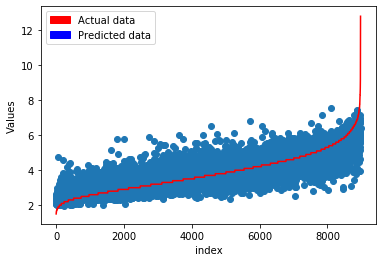

,t + 1,pred (t +1)
4506,8.6,6.845600
3595,8.7,4.624545
3318,8.7,5.169484
2293,8.8,5.690695
8792,8.9,7.178475
4307,9.2,6.774462
6671,10.3,5.628886
8666,11.5,5.330641
1626,12.3,3.945347
6253,12.8,6.405360


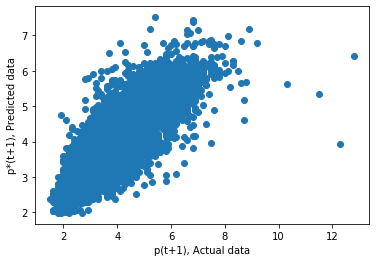

In [85]:

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(30)

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.tail(10)

In [86]:
# tempdata=pd.DataFrame(xtest.copy())
# tempdata['ytest']=ytest
# # temp=temp.dropna()
# # tempdata.head()
# # tempdata[tempdata.ytest.isna()].index

# tempdata=tempdata.drop(tempdata[tempdata.ytest.isna()].index)


xg boost
==========

In [87]:
import xgboost as xgb
# from sklearn.metrics import mean_squared_error
# import pandas as pd
# import numpy as np

In [88]:
xg_reg = xgb.XGBRegressor()
# xg_reg = xgb.XGBRegressor(objective ='reg:linear', colsample_bytree = 0.3, 
#                           learning_rate = 0.1,max_depth = 5, alpha = 10, n_estimators = 10)
xg_reg.fit(xtrain, ytrain) 

[02:47:27] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0,
             importance_type='gain', learning_rate=0.1, max_delta_step=0,
             max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
             n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
             silent=None, subsample=1, verbosity=1)

In [89]:

ypred = xg_reg.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

# ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
# ypredPD['t + 1']=ytest.values
# ypredPD['pred (t +1)']=ypred
# ypredPD.head(10)

mean_squared_error 0.39751246450000827
root mean_squared_error 0.6304858955599311
mean_absolute_error 0.46452900168757383
r2_score 0.6922073671421526


In [53]:
# ytest[ytest.isna()].shape
# tempdata.iloc[:,-1]

ANN
==========

In [33]:
model= Sequential()
model.add(Dense(input_dim=33,units=128,activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=128, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=64, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=32, activation='relu', kernel_initializer='uniform')) 
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=16, activation='relu', kernel_initializer='uniform'))
model.add(BatchNormalization())
model.add(Dropout(0.25))  
model.add(Dense(units=8, activation='relu', kernel_initializer='uniform'))
model.add(Dense(units=1, kernel_initializer='uniform'))
model.compile(loss='mean_squared_error', optimizer='Nadam', metrics=['mean_squared_error' ])

In [34]:
h=model.fit(xtrain, ytrain, validation_split=.2,epochs=100, batch_size=50)

W1003 20:56:34.952983 11444 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Train on 7195 samples, validate on 1799 samples
Epoch 1/100
7195/7195 [==============================] - 1s 146us/step - loss: 4.3330 - mean_squared_error: 4.3330 - val_loss: 30.6565 - val_mean_squared_error: 30.6565
Epoch 2/100
7195/7195 [==============================] - 0s 33us/step - loss: 0.8084 - mean_squared_error: 0.8084 - val_loss: 0.6949 - val_mean_squared_error: 0.6949
Epoch 3/100
7195/7195 [==============================] - 0s 29us/step - loss: 0.7595 - mean_squared_error: 0.7595 - val_loss: 0.9301 - val_mean_squared_error: 0.9301
Epoch 4/100
7195/7195 [==============================] - 0s 30us/step - loss: 0.6703 - mean_squared_error: 0.6703 - val_loss: 0.9116 - val_mean_squared_error: 0.9116
Epoch 5/100
7195/7195 [==============================] - 0s 33us/step - loss: 0.6154 - mean_squared_error: 0.6154 - val_loss: 0.4184 - val_mean_squared_error: 0.4184
Epoch 6/100
7195/7195 [==============================] - 0s 32us/step - loss: 0.5507 - mean_squared_error: 0.5507 - val

Epoch 50/100
7195/7195 [==============================] - 0s 30us/step - loss: 0.3210 - mean_squared_error: 0.3210 - val_loss: 0.2881 - val_mean_squared_error: 0.2881
Epoch 51/100
7195/7195 [==============================] - 0s 32us/step - loss: 0.3189 - mean_squared_error: 0.3189 - val_loss: 0.2979 - val_mean_squared_error: 0.2979
Epoch 52/100
7195/7195 [==============================] - 0s 32us/step - loss: 0.3135 - mean_squared_error: 0.3135 - val_loss: 0.3017 - val_mean_squared_error: 0.3017
Epoch 53/100
7195/7195 [==============================] - 0s 31us/step - loss: 0.3155 - mean_squared_error: 0.3155 - val_loss: 0.3567 - val_mean_squared_error: 0.3567
Epoch 54/100
7195/7195 [==============================] - 0s 30us/step - loss: 0.3200 - mean_squared_error: 0.3200 - val_loss: 0.3099 - val_mean_squared_error: 0.3099
Epoch 55/100
7195/7195 [==============================] - 0s 32us/step - loss: 0.3201 - mean_squared_error: 0.3201 - val_loss: 0.2972 - val_mean_squared_error: 0.297

7195/7195 [==============================] - 0s 32us/step - loss: 0.3143 - mean_squared_error: 0.3143 - val_loss: 0.3087 - val_mean_squared_error: 0.3087
Epoch 100/100
7195/7195 [==============================] - 0s 32us/step - loss: 0.3147 - mean_squared_error: 0.3147 - val_loss: 0.3535 - val_mean_squared_error: 0.3535


In [35]:
ypred=model.predict(xtest)

import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)

mean_squared_error 0.3604460256227187
root mean_squared_error 0.6003715729635429
mean_absolute_error 0.45564174698744414
r2_score 0.5610992779302096


,t + 1,pred (t +1)
0,3.4,3.325231
1,2.6,2.542303
2,2.3,2.520181
3,3.0,2.953143
4,6.1,6.056044
5,3.1,2.971803
6,2.3,2.529089
7,3.4,2.965737
8,5.6,4.897521
9,4.2,4.747361


dict_keys(['val_loss', 'val_mean_squared_error', 'loss', 'mean_squared_error'])


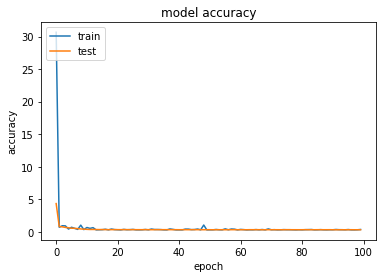

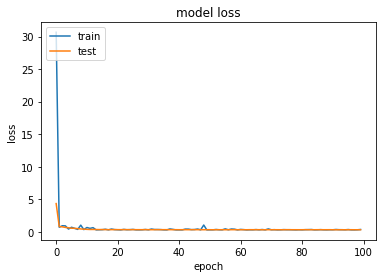

In [36]:
history=h
print(history.history.keys())
# summarize history for accuracy
plt.plot(history.history['val_loss'])
plt.plot(history.history['loss'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['val_mean_squared_error'])
plt.plot(history.history['mean_squared_error'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [37]:
ypredPD['diff']=abs(ypredPD['t + 1']- ypredPD['pred (t +1)'])
print(np.mean(ypredPD['diff']))
print(np.std(ypredPD['diff']))
print(100*ypredPD[ypredPD['diff']<=5].shape[0]/ypredPD.shape[0])

0.45564174698744403
0.3909432491103392
100.0


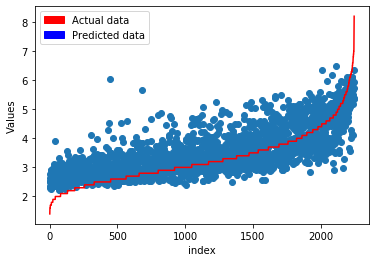

,t + 1,pred (t +1),diff
282,1.4,2.501773,1.101773
861,1.6,2.783868,1.183868
897,1.6,2.343221,0.743221
1045,1.6,2.288517,0.688517
1378,1.7,2.549014,0.849014
1455,1.7,2.636457,0.936457
2237,1.7,2.549365,0.849365
1327,1.7,2.910475,1.210475
1825,1.7,2.535621,0.835621
1462,1.7,2.532087,0.832087


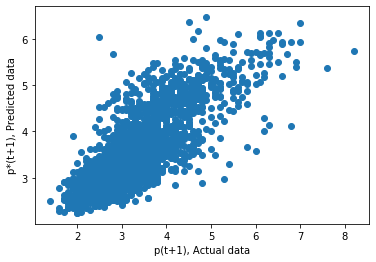

In [38]:

import matplotlib.patches as mpatches
plt.ylabel('Values')
plt.xlabel('index')
red_patch = mpatches.Patch(color='red', label='Actual data')
blue_patch = mpatches.Patch(color='blue', label='Predicted data')
plt.legend(handles=[red_patch,blue_patch])

ypredPD=ypredPD.sort_values(by=['t + 1'])
plt.scatter(np.arange(0,ypredPD.shape[0],1),ypredPD['pred (t +1)'][:ypredPD.shape[0]])
plt.plot(np.arange(0,ypredPD.shape[0],1),ypredPD['t + 1'][:ypredPD.shape[0]],color='red')
plt.show()

plt.ylabel('p*(t+1), Predicted data')
plt.xlabel('p(t+1), Actual data')
plt.scatter(ypredPD['t + 1'][:ypredPD.shape[0]],ypredPD['pred (t +1)'][:ypredPD.shape[0]])

ypredPD.head(10)

SVR
======

In [ ]:
from sklearn.svm import SVR
# svr_rbf = SVR(kernel='rbf', C=10, gamma=0.02, epsilon=.001)
svr_rbf = SVR(kernel='rbf')

In [ ]:
svr_rbf.fit(xtrain, ytrain) 

In [ ]:
ypred=svr_rbf.predict(xtest)

In [ ]:
import math
print('mean_squared_error',mean_squared_error(ytest, ypred))
print('root mean_squared_error',math.sqrt(mean_squared_error(ytest, ypred)))
print('mean_absolute_error',mean_absolute_error(ytest, ypred))
print('r2_score',r2_score(ytest, ypred))

ypredPD=pd.DataFrame()
# ypredPD['t']=xtest['S000501_x'].values
ypredPD['t + 1']=ytest.values.ravel()
ypredPD['pred (t +1)']=ypred
ypredPD.head(10)